In [1]:
import regex as re
import pickle
import requests
import numpy as np
import pandas as pd 
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from PIRM.PIRMDiscovery import CT_From_Table, Screen
to_name = pd.read_csv('gene_data/genes.csv').set_index('code')['name'].to_dict()
to_ensembl = pd.read_csv('gene_data/genes.csv').set_index('name')['code'].to_dict()
genes = [v[1] for v in to_name.items() if v[0] in pd.read_csv('gene_data/pe-rna-counts.csv')['Unnamed: 0'].tolist()]
codes = [v[0] for v in to_name.items() if v[0] in pd.read_csv('gene_data/pe-rna-counts.csv')['Unnamed: 0'].tolist()]
counts = np.log1p(pd.read_csv("gene_data/pe-rna-counts.csv", index_col=0)).loc[codes,:]
meta = pd.read_csv("gene_data/pe-rna-metadata.csv", header=None, names=["sample", "classification"])
mild = counts[meta.loc[meta['classification'] == 'Mild', 'sample'].tolist()]
severe = counts[meta.loc[meta['classification'] == 'Severe', 'sample'].tolist()]
control = counts[meta.loc[meta['classification'] == 'Control', 'sample'].tolist()]

In [2]:
def pathways_in_common(pair):
    gene1, gene2 = pair
    pattern = r'"name":"(.*?)","dataSource":'
    gene_1_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+gene1).text)
    gene_2_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+gene2).text)
    if gene_1_pathways == [] and gene_2_pathways == []:
        return -1
    return [value for value in gene_1_pathways if value in gene_2_pathways]

In [3]:
"""
A = []
num_pathways = []
B = []
pairs = list(combinations(genes, 2))
for pair in tqdm(pairs):
    pathways = pathways_in_common(pair)
    if pathways != -1 and len(pathways):
        A.append(pair)
        num_pathways.append(len(pathways))
    else:
        B.append(pair)
with open('A_B.pkl', 'wb') as f:
    pickle.dump((A,B,num_pathways), f)
"""
with open('A_B.pkl', 'rb') as f:
   A,B,num_pathways = pickle.load(f)
print(len(A))
print(len(B))

133
1947


In [4]:
def PIRM_accuracy(case, control, pairs, mode='acc'):
    acc = []
    ct_case = CT_From_Table(sample_ids = case.columns, group_label = 'case',  table=case.T)
    ct_ctrl = CT_From_Table(sample_ids = control.columns, group_label = 'control',  table=control.T)
    for pair in pairs:
        TN, TP, FN, FP = [0,0,0,0]
        s = Screen(name='s', ct_case=ct_case, ct_ctrl=ct_ctrl, pair=[to_ensembl[i] for i in list(pair)])
        for ct in [ct_case, ct_ctrl]:
            for _, sample in ct.ctp.iterrows():
                if s.classify(pd.DataFrame(sample).T)['pred'] == ct.group_label:
                    if ct.group_label == 'case':
                        TP+=1
                    else:
                        TN+=1
                else:
                    if ct.group_label == 'control':
                        FN += 1
                    else:
                        FP += 1
        if mode=='acc':
            acc.append((TP+TN)/(TP+TN+FP+FN))
        elif mode=='sens':
            acc.append(TP/(TP+FN))
        elif mode == 'spec':
            acc.append(TN/(TN+FP))
    return acc

In [5]:
def plot_zscore(ax, name, A, B, log=False):
    l = [
        f"PATHWAYS mean:{np.round(np.mean(A),2)} median:{round(np.mean(A),2)} std:{np.round(np.std(A),2)}",
        f"NO PATHWAYS:{np.round(np.mean(B),2)} median:{round(np.mean(B),2)} std:{np.round(np.std(B),2)}",
    ]
    bins = np.arange(0,1,0.05)
    z_scores_a = np.histogram(A, bins=bins)[0]/sum(np.histogram(A, bins=bins)[0])
    z_scores_b = np.histogram(B, bins=bins)[0]/sum(np.histogram(B, bins=bins)[0])
    if log:
        z_scores_a = np.log(z_scores_a)
        z_scores_b = np.log(z_scores_b)
    mean = np.mean(z_scores_a+z_scores_b)
    ax.axvline(mean, label='mean frequency')
    ax.plot(z_scores_a, bins[:-1], color='g', label=l[0])
    ax.plot(z_scores_b, bins[:-1], color='r', label=l[1])
    ax.legend(fontsize=8, loc='lower right')
    ax.set_title(name)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Z-score of Frequency')
    return ax

/tmp/ipykernel_22481/276382258.py:10: RuntimeWarning: divide by zero encountered in log
  z_scores_a = np.log(z_scores_a)
/tmp/ipykernel_22481/276382258.py:11: RuntimeWarning: divide by zero encountered in log
  z_scores_b = np.log(z_scores_b)


Text(0.5, 0.98, 'Specificity')

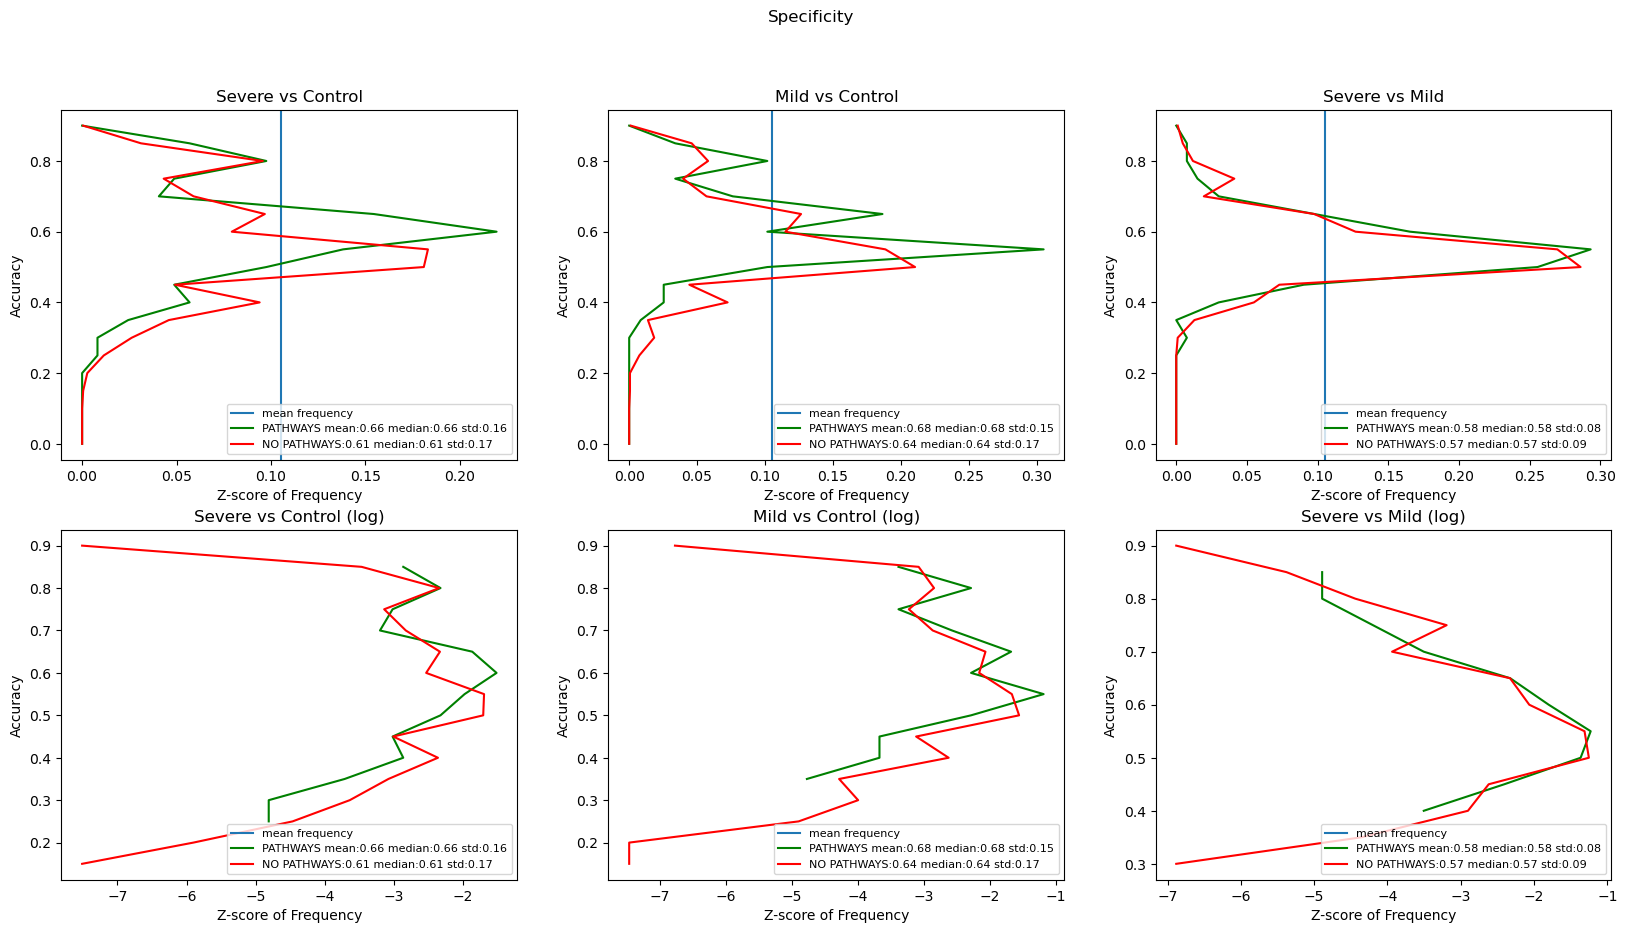

In [6]:
A_sc = PIRM_accuracy(severe, control, A, mode='spec')
B_sc = PIRM_accuracy(severe, control, B, mode='spec')
A_sm = PIRM_accuracy(severe, mild, A, mode='spec')
B_sm = PIRM_accuracy(severe, mild, B, mode='spec')
A_mc = PIRM_accuracy(mild, control, A, mode='spec')
B_mc = PIRM_accuracy(mild, control, B, mode='spec')
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0,0] = plot_zscore(axes[0,0], 'Severe vs Control', A_sc, B_sc) 
axes[0,1] = plot_zscore(axes[0,1], 'Mild vs Control', A_mc, B_mc) 
axes[0,2] = plot_zscore(axes[0,2], 'Severe vs Mild', A_sm, B_sm) 

axes[1,0] = plot_zscore(axes[1,0], 'Severe vs Control (log)', A_sc, B_sc, log=True) 
axes[1,1] = plot_zscore(axes[1,1], 'Mild vs Control (log)', A_mc, B_mc, log=True) 
axes[1,2] = plot_zscore(axes[1,2], 'Severe vs Mild (log)', A_sm, B_sm, log=True) 
plt.suptitle("Specificity")

/tmp/ipykernel_22481/276382258.py:10: RuntimeWarning: divide by zero encountered in log
  z_scores_a = np.log(z_scores_a)
/tmp/ipykernel_22481/276382258.py:11: RuntimeWarning: divide by zero encountered in log
  z_scores_b = np.log(z_scores_b)


Text(0.5, 0.98, 'Sensitivity')

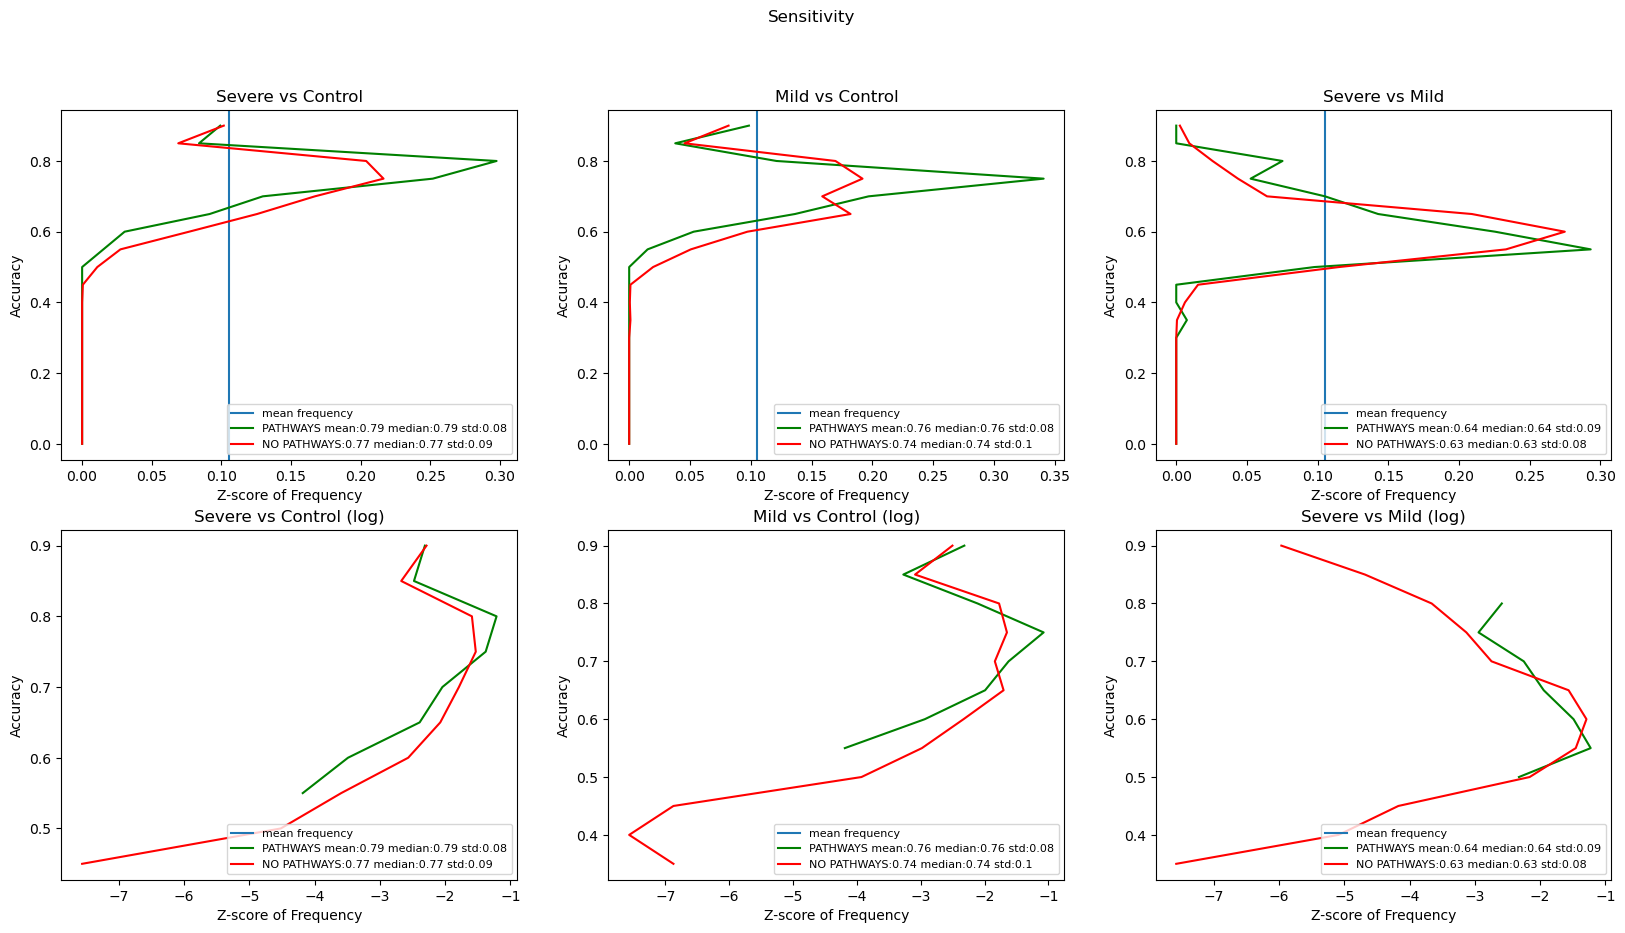

In [7]:
A_sc = PIRM_accuracy(severe, control, A, mode='sens')
B_sc = PIRM_accuracy(severe, control, B, mode='sens')
A_sm = PIRM_accuracy(severe, mild, A, mode='sens')
B_sm = PIRM_accuracy(severe, mild, B, mode='sens')
A_mc = PIRM_accuracy(mild, control, A, mode='sens')
B_mc = PIRM_accuracy(mild, control, B, mode='sens')
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes[0,0] = plot_zscore(axes[0,0], 'Severe vs Control', A_sc, B_sc) 
axes[0,1] = plot_zscore(axes[0,1], 'Mild vs Control', A_mc, B_mc) 
axes[0,2] = plot_zscore(axes[0,2], 'Severe vs Mild', A_sm, B_sm) 

axes[1,0] = plot_zscore(axes[1,0], 'Severe vs Control (log)', A_sc, B_sc, log=True) 
axes[1,1] = plot_zscore(axes[1,1], 'Mild vs Control (log)', A_mc, B_mc, log=True) 
axes[1,2] = plot_zscore(axes[1,2], 'Severe vs Mild (log)', A_sm, B_sm, log=True) 
plt.suptitle("Sensitivity")